In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pycbc import psd as psd_func
from pycbc.filter import match
from simple_pe.waveforms import generate_eccentric_waveform, shifted_f, shifted_e, calc_delta_phi

/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this p

lal.MSUN_SI != Msun


# Current functions

In [135]:
def compute_s_factor_current(h, s):
    '''
    Computes correction factor to shift a waveform back by 2pi in mean anomaly

    :param h: Unshifted waveform
    :type h: TimeSeries object, required
    :param s: Shifted waveform
    :type s: TimeSeries object, required

    :return s_factor: correction factor
    :rtype s_factor: float
    '''

    h_peaks_inds = np.diff(np.sign(np.diff(np.abs(h)))) < 0
    s_peaks_inds = np.diff(np.sign(np.diff(np.abs(s)))) < 0
    h_peaks = h.sample_times[1:-1][h_peaks_inds]
    s_peaks = s.sample_times[1:-1][s_peaks_inds]
    s_factor = 1
    if len(h_peaks) >= 2 and len(s_peaks) >= 2:
        s_denom = (1+(h_peaks[0]-s_peaks[1])/(h_peaks[1]-h_peaks[0]))
        if s_denom != 0:
            s_factor = 1/s_denom

    return s_factor


def compute_s_phi_factor_current(s, s_f_val, f_gen, e, m_total, q):

    '''
    Calculates correction factor to evolve phase back 2pi in mean anomaly.

    :param s: Shifted waveform
    :type s: TimeSeries object, required
    :param s_f_val: waveform generation frequency of shifted waveform
    :type s_f_val: float, required
    :param f_gen: waveform generation frequency
    :type f_gen: float, required
    :param e: eccentricity
    :type e: float, required
    :param m_total: total mass
    :type m_total: float, required
    :param q: inverted mass ratio
    :type q: float, required

    :return s_phi_factor: correction factor
    :rtype s_phi_factor: float
    '''

    # Calculate time of first trough
    s_troughs = np.diff(np.sign(np.diff(np.abs(s)))) > 0
    s_first_trough = s.sample_times[1:-1][s_troughs][0]
    dt = (s.sample_times[1]-s.sample_times[0])
    s_trough_ind = int((s_first_trough-s.sample_times[0])/dt)

    # Calculate frequency at first trough
    omega_i_start = (np.angle(s[1])-np.angle(s[0]))/dt
    f_i_start = np.abs(omega_i_start/(2*np.pi))
    omega_i_trough = (np.angle(s[s_trough_ind+1])-np.angle(s[s_trough_ind]))/dt
    f_i_trough = np.abs(omega_i_trough/(2*np.pi))
    f_trough = s_f_val*(f_i_trough/f_i_start)

    # Evolve over first cycle
    delta_phi = calc_delta_phi([s_first_trough, s.sample_times[0]],
                               [f_trough, s_f_val],
                               f_gen, e, m_total, q)

    # Calculate s_phi_factor
    s_start_ang = np.angle(s[0])
    s_calc_ang = (np.angle(s[s_trough_ind])+delta_phi)
    ang_diff_norm = s_start_ang % (2*np.pi) - s_calc_ang % (2*np.pi)
    s_phi_factor = 1 + ang_diff_norm/s_calc_ang

    return s_phi_factor


def get_comp_shifts_current(
    h, m_total, q, e, chi1, chi2, f_gen, s_rate, tlen, n_ecc_gen
):
    '''
    Calculates shifted frequency and eccentricity required to create each
    component waveform (beyond first).

    :param h: First unshifted waveform
    :type h: TimeSeries object, required
    :param m_total: total mass
    :type m_total: float, required
    :param q: inverted mass ratio
    :type q: float, required
    :param e: eccentricity
    :type e: float, required
    :param chi1: aligned spin of primary object
    :type chi1: float, required
    :param chi2: aligned spin of secondary object
    :type chi2: float, required
    :param f_gen: waveform generation frequency
    :type f_gen: float, required
    :param s_rate: sample rate
    :type s_rate: float, required
    :param tlen: length in seconds to resize waveforms to
    :type tlen: float, required
    :param n_ecc_gen: number of waveforms to use to generate harmonics
    :type n_ecc_gen: integer, required

    :return s_f_vals: Shifted frequency for all components beyond first
    :rtype s_f_vals: array of floats
    :return s_e_vals: Shifted eccentricity for all components beyond first
    :rtype s_e_vals: array of floats
    :return s_phi_factor: phase correction factor
    :rtype s_phi_factor: float
    '''

    s_f = shifted_f(f_gen, e, m_total, q)
    if e > 0:

        # Generate trial waveform shifted back by estimated 2pi in mean anomaly
        s_e = shifted_e(s_f, f_gen, e)
        s_wf_p, s_wf_c = generate_eccentric_waveform(
            m_total, q, s_e, chi1, chi2, s_f, s_rate,
            tlen=tlen, taper=False, to_fs=False
        )
        s_wf = s_wf_p - 1j*s_wf_c

        # Work out shift correction factor by examining peaks of both waveforms
        s_factor = compute_s_factor_current(h, s_wf)

    else:
        s_factor = 1
    if s_factor < 0.5 or s_factor > 2:
        raise RuntimeError('Unable to accurately identify how to shift '
                           'frequency and eccentricity for component '
                           'waveforms')

    # Finds shifted frequency and eccentricity of shifted waveforms
    max_s_f = f_gen - (f_gen - s_f)*s_factor
    if max_s_f <= 0:
        raise RuntimeError('Tried to generate component waveform with '
                           'negative starting frequency')
    s_f_vals = np.linspace(f_gen, max_s_f, n_ecc_gen, endpoint=False)[1:]
    s_e_vals = shifted_e(s_f_vals, f_gen, e)

    # Calculate correction factor for phases
    s_phi_factor = compute_s_phi_factor_current(s_wf, s_f, f_gen, e, m_total, q)

    return s_factor, s_phi_factor

In [268]:
# Params
m_total = 60
q = 2
e = 0.5
chi1 = 0
chi2 = 0
f_gen = 10
s_rate = 4096
tlen = 32
n_ecc_gen = 6

# Compute original waveform and s_factors
hp_orig, hc_orig = generate_eccentric_waveform(m_total, q, e, chi1, chi2, f_gen, s_rate, phase=2.47, tlen=tlen, taper=False, to_fs=False)
h_orig = hp_orig - 1j*hc_orig
s_factor, s_phi_factor = get_comp_shifts_current_iter(h_orig, m_total, q, e, chi1, chi2, f_gen, s_rate, tlen, n_ecc_gen)
print(s_factor, s_phi_factor)

# Generate new shifted waveform
s_f = shifted_f(f_gen, e, m_total, q)
s_f = f_gen - (f_gen - s_f)*s_factor
s_e = shifted_e(s_f, f_gen, e)
hp_2pi, hc_2pi = generate_eccentric_waveform(m_total, q, s_e, chi1, chi2, s_f, s_rate, tlen=tlen, taper=False, to_fs=False)
h_2pi = hp_2pi - 1j*hc_2pi
h_2pi *= np.exp(1j*(np.angle(h_orig[0])-np.angle(h_2pi[0])))
delta_phi = calc_delta_phi([h_orig.sample_times[0], h_2pi.sample_times[0]],
                           [f_gen, s_f],
                           f_gen, e, m_total, q)
h_2pi *= np.exp(1j*delta_phi*s_phi_factor)

1.0833333365656568 1.0906351098685294


In [269]:
# Generate psd
ifos = ['H1']
tlen = 32
sample_rate = 4096
f_low = 10
psds = {'H1': 'aLIGO175MpcT1800545',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])

m, _ = match(h_orig.real(), h_2pi.real(), psd=psd['H1'], low_frequency_cutoff=13)
print(m)

0.9912050529535104


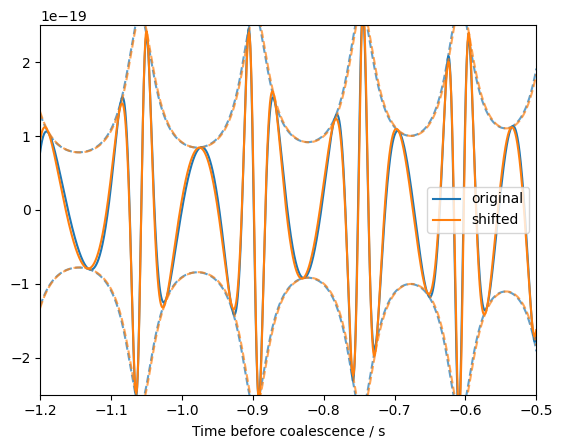

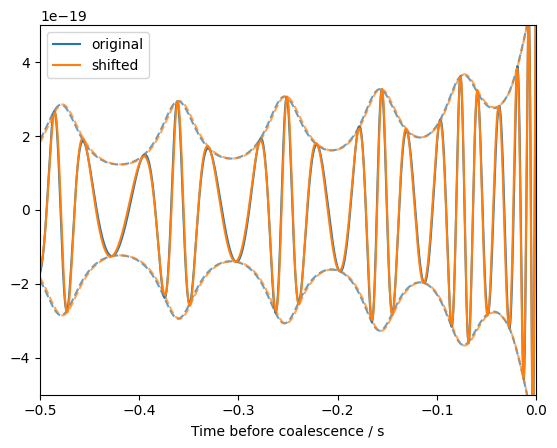

In [270]:
# Plot waveforms for comparison
plt.plot(h_orig.sample_times, h_orig, c='C0', label='original')
plt.plot(h_orig.sample_times, np.abs(h_orig), c='C0', ls='dashed', alpha=0.7)
plt.plot(h_orig.sample_times, -np.abs(h_orig), c='C0', ls='dashed', alpha=0.7)
plt.plot(h_2pi.sample_times, h_2pi, c='C1', label='shifted')
plt.plot(h_2pi.sample_times, np.abs(h_2pi), c='C1', ls='dashed', alpha=0.7)
plt.plot(h_2pi.sample_times, -np.abs(h_2pi), c='C1', ls='dashed', alpha=0.7)
plt.xlim(-1.2,-0.5)
plt.ylim(-2.5e-19, 2.5e-19)
plt.legend()
plt.xlabel('Time before coalescence / s')
plt.show()

plt.plot(h_orig.sample_times, h_orig, c='C0', label='original')
plt.plot(h_orig.sample_times, np.abs(h_orig), c='C0', ls='dashed', alpha=0.7)
plt.plot(h_orig.sample_times, -np.abs(h_orig), c='C0', ls='dashed', alpha=0.7)
plt.plot(h_2pi.sample_times, h_2pi, c='C1', label='shifted')
plt.plot(h_2pi.sample_times, np.abs(h_2pi), c='C1', ls='dashed', alpha=0.7)
plt.plot(h_2pi.sample_times, -np.abs(h_2pi), c='C1', ls='dashed', alpha=0.7)
plt.xlim(-0.5,0)
plt.ylim(-5e-19, 5e-19)
plt.legend()
plt.xlabel('Time before coalescence / s')
plt.show()

# With s_e_factor

0.3133663783515094 11.06613105348793


(0.0, 50.0)

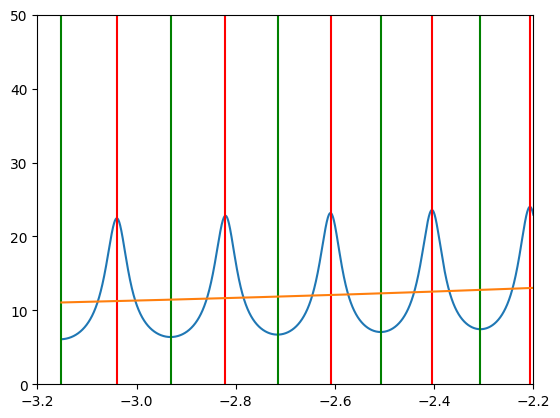

In [72]:
f_inst = -np.diff(np.angle(h_orig))/(2*np.pi*h_orig.delta_t)
f_inst[f_inst<0] = f_inst[f_inst<0] + 1/h_orig.delta_t
f_inst_peaks_inds = np.diff(np.sign(np.diff(np.abs(f_inst)))) < 0
f_inst_troughs_inds = np.diff(np.sign(np.diff(np.abs(f_inst)))) > 0
f_inst_troughs_inds[0] = 1
f_peri_times = h_orig.sample_times[2:-1][f_inst_peaks_inds]
f_peris = f_inst[1:-1][f_inst_peaks_inds][f_peri_times<0]
f_peri_times = f_peri_times[f_peri_times<0]
f_ap_times = h_orig.sample_times[2:-1][f_inst_troughs_inds]
f_aps = f_inst[1:-1][f_inst_troughs_inds][f_ap_times<0]
f_ap_times = f_ap_times[f_ap_times<0]

f_peri_interp = interp1d(f_peri_times, f_peris, kind='cubic', fill_value='extrapolate')
f_ap_interp = interp1d(f_ap_times, f_aps, kind='cubic', fill_value='extrapolate')
fine_start = np.min([f_peri_times[0], f_ap_times[0]])
fine_end = np.max([f_peri_times[-1], f_ap_times[-1]])
fine_ts = np.arange(fine_start, fine_end, h_orig.delta_t)
fine_peri = f_peri_interp(fine_ts)
fine_ap = f_ap_interp(fine_ts)

fine_es = (np.sqrt(fine_peri/fine_ap)-1)/(np.sqrt(fine_peri/fine_ap)+1)
fine_forb = (1+fine_es)**2*fine_ap/np.sqrt(1-fine_es**2)

print(fine_es[0], fine_forb[0])

plt.plot(h_orig.sample_times[1:], f_inst)
for x in h_orig.sample_times[2:-1][f_inst_peaks_inds]:
    plt.axvline(x, c='r')
for x in h_orig.sample_times[2:-1][f_inst_troughs_inds]:
    plt.axvline(x, c='g')
plt.plot(fine_ts, fine_forb)
plt.xlim(-3.2, -2.2)
plt.ylim(0, 50)

In [280]:
# CODE VERY MESSY, HARDCODED F_LOW ETC., CLEAN UP IF WANT TO IMPLEMENT

def calc_inst_e_f(f_ap, f_peri):
    '''
    Calculates instantaneous eccentricity and orbital frequency given 
    instantaneous apoapsis and periapsis frequency.

    :param f_ap: apoapsis frequency
    :type f_ap: float
    :param f_peri: periapsis frequency
    :type f_peri: float

    :return e: eccentricity
    :rtype e: float
    :return f_orb: orbital frequency
    :rtype f_orb: float
    '''

    e = (np.sqrt(f_peri/f_ap)-1)/(np.sqrt(f_peri/f_ap)+1)
    f_orb = (1+e)**2*f_ap/np.sqrt(1-e**2)

    return e, f_orb

def track_e_f(wf, return_extra=False, extra_e=None):
    '''
    Calculates eccentricity and orbital frequency of a waveform at its
    first two apoapses by examining its instantaneous frequencies.

    :param wf: Waveform
    :type wf: TimeSeries object, required

    :return es: eccentricities at first two apoapses
    :rtype es: np.array
    :return f_orbs: orbital frequencies at first two apoapses
    :rtype f_orbs: np.array
    :return ap_t_2: time of second apoapsis
    :rtype ap_t_2: float
    '''

    # Track instantaneous frequency
    f_inst = -np.diff(np.angle(wf))/(2*np.pi*wf.delta_t)
    f_inst[f_inst<0] = f_inst[f_inst<0] + 1/wf.delta_t

    # Find peaks and troughs (peri- and apoapses)    
    f_inst_peaks_inds = np.diff(np.sign(np.diff(np.abs(f_inst)))) < 0
    f_inst_troughs_inds = np.diff(np.sign(np.diff(np.abs(f_inst)))) > 0
    f_inst_troughs_inds[0] = 1
    f_peri_times = wf.sample_times[2:-1][f_inst_peaks_inds]
    f_peris = f_inst[1:-1][f_inst_peaks_inds][f_peri_times<0]
    f_peri_times = f_peri_times[f_peri_times<0]
    if len(f_peris) < 2:
        raise ValueError(
            'Waveform does not contain sufficient cycles to calculate ' +
            'instantaneous eccentricities and frequencies'
        )

    # Interpolate periapsis frequency to first and second apoapses
    f_peri_interp = interp1d(
        f_peri_times, f_peris, kind='cubic', fill_value='extrapolate'
    )
    f_peri_0, f_peri_1 = f_peri_interp(
        wf.sample_times[2:-1][f_inst_troughs_inds][:2]
    )
    f_ap_0, f_ap_1 = f_inst[1:-1][f_inst_troughs_inds][:2]

    # Calculate ecc and freq at first and second apoapses
    es, f_orbs = calc_inst_e_f(
        np.array([f_ap_0, f_ap_1]), np.array([f_peri_0, f_peri_1])
    )

    if return_extra:
        f_ap_times = wf.sample_times[2:-1][f_inst_troughs_inds]
        f_aps = f_inst[1:-1][f_inst_troughs_inds][f_ap_times<0]
        f_ap_times = f_ap_times[f_ap_times<0]
        f_ap_interp = interp1d(
            f_ap_times, f_aps, kind='cubic', fill_value='extrapolate'
        )
        ts = np.arange(wf.sample_times[0], 0, wf.delta_t)
        fs_peri = f_peri_interp(ts)
        fs_ap = f_ap_interp(ts)
        e_tracks, f_orb_tracks = calc_inst_e_f(fs_ap, fs_peri)
        orig_e_ind = np.argmin(np.abs(e_tracks-extra_e))
        extra_f = f_orb_tracks[orig_e_ind]
        return extra_f
        

    return es, f_orbs, wf.sample_times[2:-1][f_inst_troughs_inds][1]
    

def compute_s_factors_test(h, s):
    '''
    Computes correction factors to shift a waveform back by 2pi in mean anomaly

    :param h: Unshifted waveform
    :type h: TimeSeries object, required
    :param s: Shifted waveform
    :type s: TimeSeries object, required

    :return s_f_factor: correction factor on frequency
    :rtype s_f_factor: float
    :return s_e_factor: correction factor on eccentricity
    :rtype s_e_factor: float
    '''

    # Get eccentricities and frequencies at first two apoapses
    try:
        h_es, h_f_orbs, _ = track_e_f(h)
        s_es, s_f_orbs, _ = track_e_f(s)
        extra_f = track_e_f(s, return_extra=True, extra_e=h_es[0])
        extra_f *= 10/h_f_orbs[0]
    except ValueError:
        return 1, 1

    # Calculate correction factor on frequency
    s_f_denom = (1+(h_f_orbs[0]-s_f_orbs[1])/(h_f_orbs[1]-h_f_orbs[0]))
    if s_f_denom != 0:
        s_f_factor = 1/s_f_denom
    else:
        s_f_factor = 1

    # Calculate correction factor on eccentricity
    s_e_denom = (1+(h_es[0]-s_es[1])/(h_es[1]-h_es[0]))
    if s_e_denom != 0:
        s_e_factor = (1/s_e_denom)
    else:
        s_e_factor = 1
    s_e_factor = extra_f

    return s_f_factor, s_e_factor


def compute_s_phi_factor_test(s, s_f_val, f_gen, e, m_total, q):

    '''
    Calculates correction factor to evolve phase back 2pi in mean anomaly.

    :param s: Shifted waveform
    :type s: TimeSeries object, required
    :param s_f_val: waveform generation frequency of shifted waveform
    :type s_f_val: float, required
    :param f_gen: waveform generation frequency
    :type f_gen: float, required
    :param e: eccentricity
    :type e: float, required
    :param m_total: total mass
    :type m_total: float, required
    :param q: inverted mass ratio
    :type q: float, required

    :return s_phi_factor: correction factor
    :rtype s_phi_factor: float
    '''

    # Calculate frequency and time of second apoapsis
    _, s_f_orbs, s_ap_t_2 = track_e_f(s)
    s_f_orb_2 = s_f_val*(s_f_orbs[1]/s_f_orbs[0])

    # Evolve over first cycle
    delta_phi = calc_delta_phi([s_ap_t_2, s.sample_times[0]],
                               [s_f_orb_2, s_f_val],
                               f_gen, e, m_total, q)

    # Calculate s_phi_factor
    s_start_ang = np.angle(s[0])
    s_trough_ind = np.argmin(np.abs(s.sample_times-s_ap_t_2))
    s_calc_ang = (np.angle(s[s_trough_ind])+delta_phi)
    ang_diff_norm = s_start_ang % (2*np.pi) - s_calc_ang % (2*np.pi)
    s_phi_factor = 1 + ang_diff_norm/s_calc_ang

    return s_phi_factor


def shifted_e_const(s_e, e, f):
    """
    Calculates how to shift frequency to match a shifted eccentricity.

    :param s_e: Shifted starting eccentricity
    :type s_e: float, required
    :param f: Original starting frequency
    :type f: float, required
    :param e: Original starting eccentricity
    :type e: float, required

    :return s_f: Shifted starting frequency
    :rtype s_f: float
    """

    # Handle non-eccentric case
    if e == 0:
        return np.zeros_like(s_e)
    elif e == 1:
        return np.ones_like(s_e)

    # Calculate constant of proportionality
    constant = f*e**(18/19)*(1+(121/304)*e**2)**(1305/2299)*(1-e**2)**(-3/2)

    # Create interpolation function and interpolate
    e_interps = np.linspace(0, 1, 10**6)[1:]
    e_term_1 = e_interps**(-18/19)
    e_term_2 = (1+(121/304)*e_interps**2)**(-1305/2299)
    e_term_3 = (1-e_interps**2)**(3/2)
    f_interps = constant*e_term_1*e_term_2*e_term_3
    f_interps = np.insert(f_interps, 0, np.inf)
    e_interps = np.insert(e_interps, 0, 0)
    ef_interp_fn = interp1d(e_interps, f_interps)

    try:
        s_f = ef_interp_fn(s_e)
    except ValueError:
        raise ValueError(f'shifted_e interp failed with s_e={s_e}, '
                         + f'f={f}, e={e}')

    return s_f


def get_comp_shifts_test(
    h, m_total, q, e, chi1, chi2, f_gen, s_rate, tlen, n_ecc_gen
):
    '''
    Calculates shifted frequency and eccentricity required to create each
    component waveform (beyond first).

    :param h: First unshifted waveform
    :type h: TimeSeries object, required
    :param m_total: total mass
    :type m_total: float, required
    :param q: inverted mass ratio
    :type q: float, required
    :param e: eccentricity
    :type e: float, required
    :param chi1: aligned spin of primary object
    :type chi1: float, required
    :param chi2: aligned spin of secondary object
    :type chi2: float, required
    :param f_gen: waveform generation frequency
    :type f_gen: float, required
    :param s_rate: sample rate
    :type s_rate: float, required
    :param tlen: length in seconds to resize waveforms to
    :type tlen: float, required
    :param n_ecc_gen: number of waveforms to use to generate harmonics
    :type n_ecc_gen: integer, required

    :return s_f_vals: Shifted frequency for all components beyond first
    :rtype s_f_vals: array of floats
    :return s_e_vals: Shifted eccentricity for all components beyond first
    :rtype s_e_vals: array of floats
    :return s_phi_factor: phase correction factor
    :rtype s_phi_factor: float
    '''

    overall_s_f_factor = 1
    overall_s_e_factor = 0
    max_iter = 4
    
    for i in range(max_iter):

        # Generate trial waveform shifted back by estimated 2pi in mean anomaly
        s_f = shifted_f(f_gen, e, m_total, q)
        s_f = f_gen - (f_gen - s_f)*overall_s_f_factor
        s_e = shifted_e(s_f, f_gen-overall_s_e_factor, e)
        s_wf_p, s_wf_c = generate_eccentric_waveform(
            m_total, q, s_e, chi1, chi2, s_f, s_rate,
            tlen=tlen, taper=False, to_fs=False
        )
        s_wf = s_wf_p - 1j*s_wf_c
        
        if e > 0:
            # Work out shift correction factor by examining peaks of both waveforms
            s_f_factor, s_e_factor = compute_s_factors_test(h, s_wf)
            s_f_2 = shifted_e_const(s_e, e, s_e_factor)
            s_e_factor = s_f_2-s_f
        else:
            s_f_factor = 1
            s_e_factor = 0
        # if np.min([s_f_factor, s_e_factor]) < 0.5 or np.max([s_f_factor, s_e_factor]) > 2:
        #     raise RuntimeError('Unable to accurately identify how to shift '
        #                        'frequency and eccentricity for component '
        #                        'waveforms')
        overall_s_f_factor *= s_f_factor
        overall_s_e_factor = s_e_factor

    # # Finds shifted frequency and eccentricity of shifted waveforms
    # max_s_f = f_gen - (f_gen - s_f)*s_f_factor
    # if max_s_f <= 0:
    #     raise RuntimeError('Tried to generate component waveform with '
    #                        'negative starting frequency')
    # s_f_vals = np.linspace(f_gen, max_s_f, n_ecc_gen, endpoint=False)[1:]
    # s_e_vals = shifted_e(s_f_vals, f_gen, e)
    # s_e_vals = e - (e - s_e_vals)*s_e_factor

    # Calculate correction factor for phases
    s_phi_factor = compute_s_phi_factor_current(s_wf, s_f, f_gen, e, m_total, q)

    return overall_s_f_factor, overall_s_e_factor, s_phi_factor

In [253]:
# Params
m_total = 60
q = 2
e = 0.5
chi1 = 0
chi2 = 0
f_gen = 10
s_rate = 4096
tlen = 32
n_ecc_gen = 6

# Compute original waveform and s_factors
hp_orig, hc_orig = generate_eccentric_waveform(m_total, q, e, chi1, chi2, f_gen, s_rate, phase=2.47, tlen=tlen, taper=False, to_fs=False)
h_orig = hp_orig - 1j*hc_orig
s_f_factor, s_e_factor, s_phi_factor = get_comp_shifts_test(h_orig, m_total, q, e, chi1, chi2, f_gen, s_rate, tlen, n_ecc_gen)
print(s_f_factor, s_e_factor, s_phi_factor)

# Generate new shifted waveform
s_f = shifted_f(f_gen, e, m_total, q)
s_f = f_gen - (f_gen - s_f)*s_f_factor
s_e = shifted_e(s_f, f_gen-s_e_factor, e)
hp_2pi, hc_2pi = generate_eccentric_waveform(m_total, q, s_e, chi1, chi2, s_f, s_rate, tlen=tlen, taper=False, to_fs=False)
h_2pi = hp_2pi - 1j*hc_2pi
h_2pi *= np.exp(1j*(np.angle(h_orig[0])-np.angle(h_2pi[0])))
delta_phi = calc_delta_phi([h_orig.sample_times[0], h_2pi.sample_times[0]],
                           [f_gen, s_f],
                           f_gen, e, m_total, q)
h_2pi *= np.exp(1j*delta_phi*s_phi_factor)

[0.39914821 0.38448355] [0.41384759 0.39937832]
1.0445190693406754 0.034546345165175296
[0.39914821 0.38448355] [0.41379954 0.39940431]
0.9841123390244527 0.032726148616816886
1.0279241044844967 0.032726148616816886 1.0903335251610127


In [254]:
# Generate psd
ifos = ['H1']
tlen = 32
sample_rate = 4096
f_low = 10
psds = {'H1': 'aLIGO175MpcT1800545',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])

m, _ = match(h_orig.real(), h_2pi.real(), psd=psd['H1'], low_frequency_cutoff=13)
print(m)

0.9934914696472398


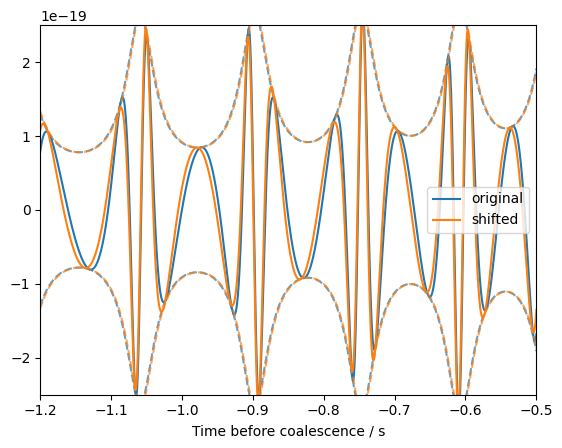

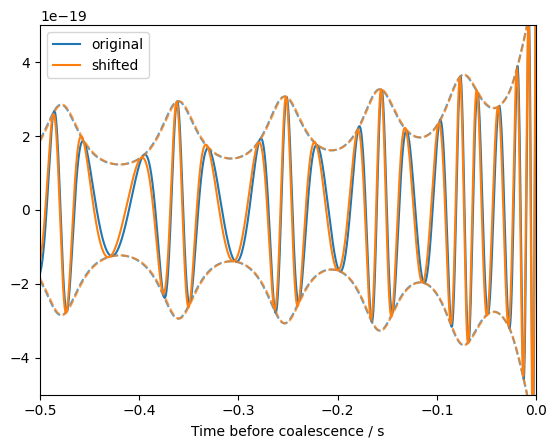

In [255]:
# Plot waveforms for comparison
plt.plot(h_orig.sample_times, h_orig, c='C0', label='original')
plt.plot(h_orig.sample_times, np.abs(h_orig), c='C0', ls='dashed', alpha=0.7)
plt.plot(h_orig.sample_times, -np.abs(h_orig), c='C0', ls='dashed', alpha=0.7)
plt.plot(h_2pi.sample_times, h_2pi, c='C1', label='shifted')
plt.plot(h_2pi.sample_times, np.abs(h_2pi), c='C1', ls='dashed', alpha=0.7)
plt.plot(h_2pi.sample_times, -np.abs(h_2pi), c='C1', ls='dashed', alpha=0.7)
plt.xlim(-1.2,-0.5)
plt.ylim(-2.5e-19, 2.5e-19)
plt.legend()
plt.xlabel('Time before coalescence / s')
plt.show()

plt.plot(h_orig.sample_times, h_orig, c='C0', label='original')
plt.plot(h_orig.sample_times, np.abs(h_orig), c='C0', ls='dashed', alpha=0.7)
plt.plot(h_orig.sample_times, -np.abs(h_orig), c='C0', ls='dashed', alpha=0.7)
plt.plot(h_2pi.sample_times, h_2pi, c='C1', label='shifted')
plt.plot(h_2pi.sample_times, np.abs(h_2pi), c='C1', ls='dashed', alpha=0.7)
plt.plot(h_2pi.sample_times, -np.abs(h_2pi), c='C1', ls='dashed', alpha=0.7)
plt.xlim(-0.5,0)
plt.ylim(-5e-19, 5e-19)
plt.legend()
plt.xlabel('Time before coalescence / s')
plt.show()

# Compare methods

In [284]:
def get_comp_shifts_current_iter(
    h, m_total, q, e, chi1, chi2, f_gen, s_rate, tlen, n_ecc_gen
):
    '''
    Calculates shifted frequency and eccentricity required to create each
    component waveform (beyond first).

    :param h: First unshifted waveform
    :type h: TimeSeries object, required
    :param m_total: total mass
    :type m_total: float, required
    :param q: inverted mass ratio
    :type q: float, required
    :param e: eccentricity
    :type e: float, required
    :param chi1: aligned spin of primary object
    :type chi1: float, required
    :param chi2: aligned spin of secondary object
    :type chi2: float, required
    :param f_gen: waveform generation frequency
    :type f_gen: float, required
    :param s_rate: sample rate
    :type s_rate: float, required
    :param tlen: length in seconds to resize waveforms to
    :type tlen: float, required
    :param n_ecc_gen: number of waveforms to use to generate harmonics
    :type n_ecc_gen: integer, required

    :return s_f_vals: Shifted frequency for all components beyond first
    :rtype s_f_vals: array of floats
    :return s_e_vals: Shifted eccentricity for all components beyond first
    :rtype s_e_vals: array of floats
    :return s_phi_factor: phase correction factor
    :rtype s_phi_factor: float
    '''

    overall_s_factor = 1
    max_iter = 2
    for i in range(max_iter):
        s_f = shifted_f(f_gen, e, m_total, q)
        s_f = f_gen - (f_gen - s_f)*overall_s_factor
        if e > 0:
    
            # Generate trial waveform shifted back by estimated 2pi in mean anomaly
            s_e = shifted_e(s_f, f_gen, e)
            s_wf_p, s_wf_c = generate_eccentric_waveform(
                m_total, q, s_e, chi1, chi2, s_f, s_rate,
                tlen=tlen, taper=False, to_fs=False
            )
            s_wf = s_wf_p - 1j*s_wf_c
    
            # Work out shift correction factor by examining peaks of both waveforms
            s_factor = compute_s_factor_current(h, s_wf)
    
        else:
            s_factor = 1
        overall_s_factor *= s_factor
        if s_factor < 0.5 or s_factor > 2:
            raise RuntimeError('Unable to accurately identify how to shift '
                               'frequency and eccentricity for component '
                               'waveforms')
    
    # # Finds shifted frequency and eccentricity of shifted waveforms
    # max_s_f = f_gen - (f_gen - s_f)*s_factor
    # if max_s_f <= 0:
    #     raise RuntimeError('Tried to generate component waveform with '
    #                        'negative starting frequency')
    # s_f_vals = np.linspace(f_gen, max_s_f, n_ecc_gen, endpoint=False)[1:]
    # s_e_vals = shifted_e(s_f_vals, f_gen, e)

    # Calculate correction factor for phases
    s_phi_factor = compute_s_phi_factor_current(s_wf, s_f, f_gen, e, m_total, q)

    return overall_s_factor, s_phi_factor

In [287]:
# Params
m_total = 40
q = 2
chi1 = 0
chi2 = 0
f_gen = 10
s_rate = 4096
tlen = 32
n_ecc_gen = 6

m_current = []
m_test = []
for i, e in enumerate(np.linspace(0, 0.7, 15)):

    try:
        # Compute original waveform and s_factors
        hp_orig, hc_orig = generate_eccentric_waveform(m_total, q, e, chi1, chi2, f_gen, s_rate, phase=2.47, tlen=tlen, taper=False, to_fs=False)
        h_orig = hp_orig - 1j*hc_orig
        s_factor, s_phi_factor = get_comp_shifts_current_iter(h_orig, m_total, q, e, chi1, chi2, f_gen, s_rate, tlen, n_ecc_gen)
        
        # Generate new shifted waveform
        s_f = shifted_f(f_gen, e, m_total, q)
        s_f = f_gen - (f_gen - s_f)*s_factor
        s_e = shifted_e(s_f, f_gen, e)
        hp_2pi, hc_2pi = generate_eccentric_waveform(m_total, q, s_e, chi1, chi2, s_f, s_rate, tlen=tlen, taper=False, to_fs=False)
        h_2pi = hp_2pi - 1j*hc_2pi
        h_2pi *= np.exp(1j*(np.angle(h_orig[0])-np.angle(h_2pi[0])))
        delta_phi = calc_delta_phi([h_orig.sample_times[0], h_2pi.sample_times[0]],
                                   [f_gen, s_f],
                                   f_gen, e, m_total, q)
        h_2pi *= np.exp(1j*delta_phi*s_phi_factor)
    
        m, _ = match(h_orig.real(), h_2pi.real(), psd=psd['H1'], low_frequency_cutoff=13)
        m_current.append(m)
    except:
        m_current.append(0)

    try:
        # Compute original waveform and s_factors
        hp_orig, hc_orig = generate_eccentric_waveform(m_total, q, e, chi1, chi2, f_gen, s_rate, phase=2.47, tlen=tlen, taper=False, to_fs=False)
        h_orig = hp_orig - 1j*hc_orig
        s_f_factor, s_e_factor, s_phi_factor = get_comp_shifts_test(h_orig, m_total, q, e, chi1, chi2, f_gen, s_rate, tlen, n_ecc_gen)
        
        # Generate new shifted waveform
        s_f = shifted_f(f_gen, e, m_total, q)
        s_f = f_gen - (f_gen - s_f)*s_f_factor
        s_e = shifted_e(s_f, f_gen-s_e_factor, e)
        hp_2pi, hc_2pi = generate_eccentric_waveform(m_total, q, s_e, chi1, chi2, s_f, s_rate, tlen=tlen, taper=False, to_fs=False)
        h_2pi = hp_2pi - 1j*hc_2pi
        h_2pi *= np.exp(1j*(np.angle(h_orig[0])-np.angle(h_2pi[0])))
        delta_phi = calc_delta_phi([h_orig.sample_times[0], h_2pi.sample_times[0]],
                                   [f_gen, s_f],
                                   f_gen, e, m_total, q)
        h_2pi *= np.exp(1j*delta_phi*s_phi_factor)
        m, _ = match(h_orig.real(), h_2pi.real(), psd=psd['H1'], low_frequency_cutoff=13)
        m_test.append(m)
    except:
        m_test.append(0)

    print(f'\r{i+1} done out of 15', end='')

15 done out of 15

(0.9, 1.0)

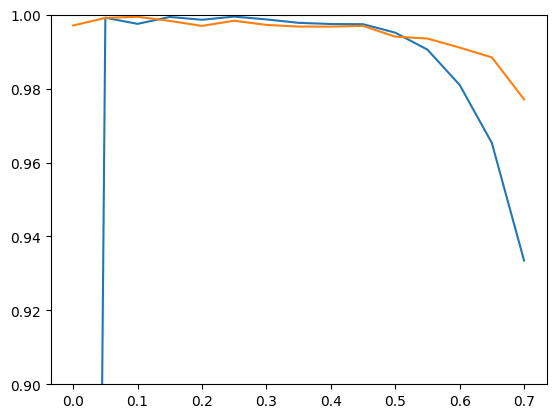

In [288]:
plt.plot(np.linspace(0, 0.7, 15), m_current, label='current method')
plt.plot(np.linspace(0, 0.7, 15), m_test, label='test method')
plt.ylim(0.9,1)